In [1]:
import pandas as pd
import json
from typing import List
import math
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

# 显示所有列
pd.set_option('display.max_columns', None)
# 显示所有行
pd.set_option('display.max_rows', None)

In [7]:
def read_file(path: str, mode: str = "train", text_type: str = "A"):
    data = []
    with open(path, "r", encoding="utf-8") as fr:
        for line in fr:
            tmp = []
            line: dict = json.loads(line)
            source = line["source"]
            target = line["target"]
            tmp.extend([source, target])
            if mode.strip().lower() == "train":
                label = line["labelA"] if text_type == "A" else line["labelB"]
                tmp.append(label)
            elif mode.strip().lower() == "test":
                text_id = line["id"]
                tmp.append(text_id)
            data.append(tmp)
        
    return data

In [8]:
train_columns = ["source", "target", "label"]
test_columns = ["source", "target", "id"]

## short vs short

### A match

In [9]:
# ssa train
ssa_train = read_file("../data/raw/round1/ssa/train.txt", "train", "A")
ssa_valid = read_file("../data/raw/round1/ssa/valid.txt", "train", "A")
ssa_test = read_file("../data/raw/round1/ssa/test_with_id.txt", "test", "A")

ssa_train_df = pd.DataFrame(ssa_train, columns=train_columns)
ssa_valid_df = pd.DataFrame(ssa_valid, columns=train_columns)
ssa_test_df = pd.DataFrame(ssa_test, columns=test_columns)

print(f"ssa train: {ssa_train_df.shape}, ssa valid: {ssa_valid_df.shape}, ssa test: {ssa_test_df.shape}")

ssa train: (9867, 3), ssa valid: (1645, 3), ssa test: (4934, 3)


In [10]:
ssa_train_df["label"].value_counts()[0]

7094

In [11]:
print(ssa_train_df.shape)
# ssa train label distrubute
ssa_train_dist = ssa_train_df["label"].value_counts()
print("label distribute\n", ssa_train_dist)
print(f"ssa train label 0/1 distribute: {ssa_train_dist[0] / ssa_train_dist[1]:.4f}")
ssa_train_df.head()

(9867, 3)
label distribute
 0    7094
1    2773
Name: label, dtype: int64
ssa train label 0/1 distribute: 2.5582


,source,target,label
0,谁能打破科比81分纪录？奥尼尔给出5个候选人，补充利拉德比尔！,NBA现役能入名人堂的球星很多，但是能被立铜像只有2人,0
1,请扩散！明天，黄金埠这些地方会停电！,生活｜这几个地方注意啦！1月12日有部分线路停电检修,0
2,居家健身增强免疫！（三）,原来是背影杀手#你愿意和我做朋友吗#户外健身,0
3,太极拳罗师傅被洋人打伤，叶问霸气复仇？,非常完美：感动！女嘉宾告白赵杰被拒绝，尹康霸气上台挽留！,0
4,恭喜哈登！篮网因祸得福，29+7超巨大概率复出，3换4交易方案出炉,三英缺席杜兰特，篮网迎战湖人NBA重头大戏！,1


In [12]:
print(ssa_valid_df.shape)
# ssa valid label distrubute
ssa_valid_dist = ssa_valid_df["label"].value_counts()
print("ssa valid label distribute\n", ssa_valid_dist)
print(f"ssa valid label 0/1 distribute: {ssa_valid_dist[0] / ssa_valid_dist[1]:.4f}")
ssa_valid_df.head()

(1645, 3)
ssa valid label distribute
 0    1160
1     485
Name: label, dtype: int64
ssa valid label 0/1 distribute: 2.3918


,source,target,label
0,【春节档】据说《刺杀小说家》是全宇宙最好的剧组,《刺杀小说家》两个世界，一场奇幻冒险！,1
1,央广网北京2月25日消息（记者韩靖陈锐海）2021年2月25日16时，北京市朝阳区太阳宫北街...,据@新华视点消息，2021年2月25日16时，北京市朝阳区太阳宫北街1号，国家乡村振兴局牌子...,1
2,晒晒主持人程雷的豪宅，小区看起来有些年头，生活过得普通又节俭,带你参观张铎的豪宅，跟老婆生活很恩爱，在家餐厅布置非常浪漫,0
3,当时，勇士成功进行了24秒的防守，导致马刺未能将球打进。在格林准备发球的时候，德罗赞走向库里...,这场比赛，勇士队状态非常好，库里与乌布雷首节联手轰下25分，帮助勇士队取得领先。这场比赛，格...,1
4,凡是不愿说破的，也最怕别人点透,“小阎罗”茸主第二局TKO‘牧马人“毕德力雅，成功卫冕金腰带,0


In [13]:
ssa_train_src_len = ssa_train_df["source"].str.len().tolist()
ssa_valid_src_len = ssa_valid_df["source"].str.len().tolist()
ssa_train_src_len = ssa_train_src_len + ssa_valid_src_len
print(len(ssa_train_src_len))
ssa_train_src_len[:5]

11512


[31, 18, 12, 19, 33]

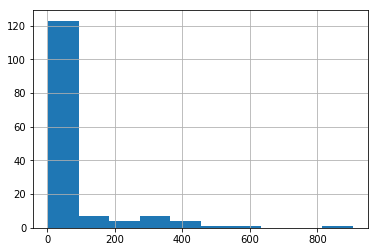

In [14]:
# train valid source length distribute
pd.Series(ssa_train_src_len).value_counts().hist()
plt.show()

In [15]:
ssa_train_tgt_len = ssa_train_df["target"].str.len().tolist()
ssa_valid_tgt_len = ssa_valid_df["target"].str.len().tolist()
ssa_train_tgt_len = ssa_train_tgt_len + ssa_valid_tgt_len
print(len(ssa_train_tgt_len))
ssa_train_tgt_len[:5]

11512


[27, 26, 22, 30, 22]

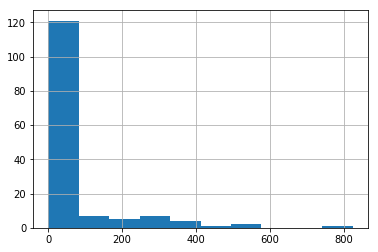

In [16]:
# train valid target length distribute
pd.Series(ssa_train_tgt_len).value_counts().hist()
plt.show()

### B strict match

In [16]:
# ssb train
ssb_train = read_file("../data/raw/ssb/train.txt", "train", "B")
ssb_valid = read_file("../data/raw/ssb/valid.txt", "train", "B")
ssb_test = read_file("../data/raw/ssb/test_with_id.txt", "test", "B")

ssb_train_df = pd.DataFrame(ssb_train, columns=train_columns)
ssb_valid_df = pd.DataFrame(ssb_valid, columns=train_columns)
ssb_test_df = pd.DataFrame(ssb_test, columns=test_columns)

print(f"ssb train: {ssb_train_df.shape}, ssb valid: {ssb_valid_df.shape}, ssb test: {ssb_test_df.shape}")

ssb train: (9858, 3), ssb valid: (1643, 3), ssb test: (4930, 3)


In [17]:
print(ssa_train_df.shape)
# ssb train label distrubute
ssb_train_dist = ssb_train_df["label"].value_counts()
print("label distribute\n",ssb_train_dist)
print(f"ssb train label 0/1 distribute: {ssb_train_dist[0] / ssb_train_dist[1]:.4f}")
ssb_train_df.head()

(9867, 3)
label distribute
 0    8619
1    1239
Name: label, dtype: int64
ssb train label 0/1 distribute: 6.9564


,source,target,label
0,网红32步广场舞《爱不需要任何理由》柔情动听DJ版，背面演示,热门流行曲《笑踏人生路》32步广场舞，背正面演示！,0
1,王宝强展示少林功夫螳螂拳震撼全场,功夫高手南北位断臂裸绞，内蒙硬汉肘击拳砸逆袭中亚冠军,0
2,2021选秀浪潮来袭，有600位男生在等你！偶像、导师、粉丝真不够用了！,选秀节目名场面之“秀腹肌”,0
3,魏文亮董建春李丁相声《4G时代》，台下妹子笑得直捶腿！,李鸣宇王文林相声《捉放擎天柱》，把艺术糟蹋到极致了！,0
4,开学季 全省大、中、小学校将于近期陆续开学，为确保校园消防安全，云南消防准备了满满的消防安全...,开学季 全省大、中、小学校将于近期陆续开学，为确保校园消防安全，云南消防准备了满满的消防安全...,1


In [18]:
print(ssb_valid_df.shape)
# ssb valid label distrubute
print("label distribute\n", ssb_valid_df["label"].value_counts())
ssb_valid_df.head()

(1643, 3)
label distribute
 0    1439
1     204
Name: label, dtype: int64


,source,target,label
0,赵继伟单节15分！26+10极限拯救辽宁，郭艾伦才10分在场又梦游,5战4败！CBA夺冠热门又崩盘，超级外援组合联手造大冷,0
1,工程师上线！在线解答安排！,刚破壳的小鸡，刚出生就已经被安排得明明白白，难怪炸鸡店不断货,0
2,这句歌词非常直接地重现了科比发生意外的方式——坠机，所以被指责为不尊重死者和消费科比。但你本...,后来到了凯尔特人，为了总冠军，他转换了自己的打法，成为无球跑动球员，这次转变无疑是非常成功的。,0
3,元宵节刚过冷空气“大礼包”又上线了中东部地区将迎来大范围雨雪天气东北地区将出现强降温过去一天...,辽东半岛、黄淮、江淮、江汉等地的部分地区有4～6级风，阵风7～8级；东北地区东部、黄淮南部、...,0
4,WTT赛事是商业赛事，性质上只代表球员个人而不代表国家，但日本乒协提出了严格的选拔办法，显然...,伊藤美诚、早田希娜晋级，即将再次巅峰对决1月16日上午，日本乒乓球全国锦标赛结束了2场焦点大...,1


In [19]:
ssb_train_src_len = ssb_train_df["source"].str.len().tolist()
ssb_valid_src_len = ssb_valid_df["source"].str.len().tolist()
ssb_train_src_len = ssb_train_src_len + ssb_valid_src_len
print(len(ssb_train_src_len))
ssb_train_src_len[:5]

11501


[30, 16, 36, 29, 58]

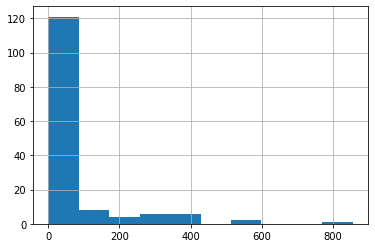

In [20]:
# train valid source length distribute
pd.Series(ssb_train_src_len).value_counts().hist()
plt.show()

In [21]:
ssb_train_tgt_len = ssb_train_df["target"].str.len().tolist()
ssb_valid_tgt_len = ssb_valid_df["target"].str.len().tolist()
ssb_train_tgt_len = ssb_train_tgt_len + ssb_valid_tgt_len
print(len(ssb_train_tgt_len))
ssb_train_tgt_len[:5]

11501


[27, 28, 13, 28, 58]

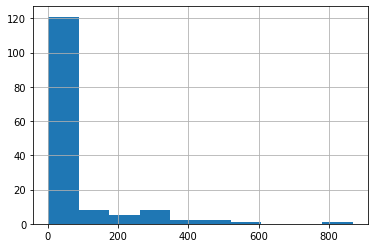

In [22]:
# train valid target length distribute
pd.Series(ssb_train_tgt_len).value_counts().hist()
plt.show()

## short vs long

### A match

In [23]:
# sla train
sla_train = read_file("../data/raw/sla/train.txt", "train", "A")
sla_valid = read_file("../data/raw/sla/valid.txt", "train", "A")
sla_test = read_file("../data/raw/sla/test_with_id.txt", "test", "A")

sla_train_df = pd.DataFrame(sla_train, columns=train_columns)
sla_valid_df = pd.DataFrame(sla_valid, columns=train_columns)
sla_test_df = pd.DataFrame(sla_test, columns=test_columns)

print(f"sla train: {sla_train_df.shape}, sla valid: {sla_valid_df.shape}, sla test: {sla_test_df.shape}")

sla train: (9936, 3), sla valid: (1656, 3), sla test: (4969, 3)


In [24]:
print(sla_train_df.shape)
# sla train label distrubute
sla_train_dist = sla_train_df["label"].value_counts()
print("label distribute\n", sla_train_dist)
print(f"sla train label 0/1 distribute: {sla_train_dist[0] / sla_train_dist[1]:.4f}")
sla_train_df.head()

(9936, 3)
label distribute
 0    6371
1    3565
Name: label, dtype: int64
sla train label 0/1 distribute: 1.7871


,source,target,label
0,世界顶尖级的鞍马竞赛，动作很到位！,全文共962字，阅读大约需要2分20秒。 “ 我们坚定地认为，“身体和灵魂，总有一个要...,0
1,鸬鹚与鱼，杭州翁剑敏/摄影 普通鸬鹚，大型水鸟。在中国南方较常见。通体黑色，头颈具紫绿色光...,【好消息！钱塘江新建大桥最快6月合龙】看浙里钱塘江新建大桥位于彭埠大桥（钱江二桥）下游侧，全...,0
2,据大连市纪委监委消息：1月13日晚，网络传出大连市金普新区一女子进小区拒不配合志愿者登记并给...,据大连市纪委监委消息：1月13日晚，网络传出大连市金普新区一女子进小区拒不配合志愿者登记并给...,0
3,诠释何为英雄本色，这就是巴蒂。 免责声明平台重在分享，除署名外其余内容均来自网络，我们对文...,近日，湖人球星勒布朗在社交媒体上晒出一组电影《空中大灌篮2：新传奇》的剧照，他也登上了《娱乐...,0
4,大 红 包 爆笑喜剧电影《大红包》提档1月22日，正式拉响2021新年喜剧贺岁的首战号角...,大红包抢先看 开年必须哈哈哈 大 红 包 爆笑喜剧电影《大红包》1月22日上映，“特...,1


In [25]:
print(sla_valid_df.shape)
# sla valid label distrubute
print("label distribute\n", sla_valid_df["label"].value_counts())
sla_valid_df.head()

(1656, 3)
label distribute
 0    1040
1     616
Name: label, dtype: int64


,source,target,label
0,北京：储存温度0℃以下的进口冷链食品全追溯,新京报快讯（记者陈琳）“北京冷链”平台自去年11月1日正式上线运行，进口冷藏冷冻肉类、水产品...,1
1,党中央推进的这项工作，基层干部都说好！,驰而不息，交出人民满意答卷 2020年12月28日，中央纪委国家监委公开通报6起违反中央八项...,0
2,沈祥福加盟深足因崇明岛模式理念曾拒恒大足校高薪邀约,北京时间2月1日下午15点，深足传来喜讯，据国内媒体《新快报》足球记者王敌报道，在加盟深足出...,1
3,【992|发布】全程可追溯，疫苗生产流通管理规定征求意见发布,中欧地理标志协定今天（3月1日）正式生效。这是中国对外商签的第一个全面的、高水平的地理标志协...,0
4,曼联欲卖6000万真核换此人可他违约金7.5亿，能否如愿呢？,目前曼联的状态较为完美，这个赛季曼联在各项赛事当中的表现较为出色，这个赛季他们也成功引进了卡...,1


In [26]:
sla_train_src_len = sla_train_df["source"].str.len().tolist()
sla_valid_src_len = sla_valid_df["source"].str.len().tolist()
sla_train_src_len = sla_train_src_len + sla_valid_src_len
print(len(sla_train_src_len))
sla_train_src_len[:5]

11592


[19, 101, 62, 102, 150]

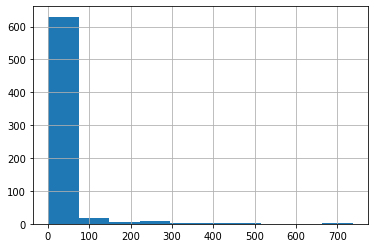

In [27]:
# train valid source length distribute
pd.Series(sla_train_src_len).value_counts().hist()
plt.show()

In [28]:
sla_train_tgt_len = sla_train_df["target"].str.len().tolist()
sla_valid_tgt_len = sla_valid_df["target"].str.len().tolist()
sla_train_tgt_len = sla_train_tgt_len + sla_valid_tgt_len
print(len(sla_train_tgt_len))
sla_train_tgt_len[:5]

11592


[951, 159, 829, 551, 564]

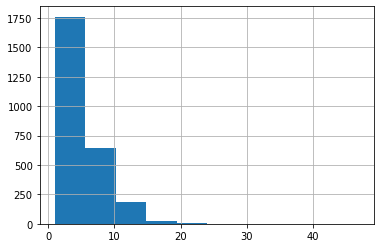

In [29]:
# train valid target length distribute
pd.Series(sla_train_tgt_len).value_counts().hist()
plt.show()

### B strict match

In [30]:
# slb train
slb_train = read_file("../data/raw/slb/train.txt", "train", "B")
slb_valid = read_file("../data/raw/slb/valid.txt", "train", "B")
slb_test = read_file("../data/raw/slb/test_with_id.txt", "test", "B")

slb_train_df = pd.DataFrame(slb_train, columns=train_columns)
slb_valid_df = pd.DataFrame(slb_valid, columns=train_columns)
slb_test_df = pd.DataFrame(slb_test, columns=test_columns)

print(f"slb train: {slb_train_df.shape}, slb valid: {slb_valid_df.shape}, slb test: {slb_test_df.shape}")

slb train: (9937, 3), slb valid: (1656, 3), slb test: (4969, 3)


In [31]:
print(slb_train_df.shape)
# slb train label distrubute
slb_train_dist = slb_train_df["label"].value_counts()
print("label distribute\n", slb_train_dist)
print(f"slb train label 0/1 distribute: {slb_train_dist[0] / slb_train_dist[1]:.4f}")
slb_train_df.head()

(9937, 3)
label distribute
 0    8290
1    1647
Name: label, dtype: int64
slb train label 0/1 distribute: 5.0334


,source,target,label
0,陈立农、小鬼亮相腾讯音乐娱乐盛典红毯金发贵公子+红发脏辫鬼少帅出特色,今日，腾讯音乐娱乐盛典在澳门举行，虽然坤坤今天没有走红毯，但依旧存在感满分，前辈任贤齐谈及欣...,0
1,1月15日，吉林长春，吉林大学放寒假的学生乘坐大巴准备前往车站返乡。当日起，吉林大学...,14日下午，河北省召开第五场疫情防控新闻发布会，对疫情防控相关情况进行通报。 1月14日，...,0
2,每日经济新闻,每经记者：陈鹏丽每经编辑：张海妮 近日，全国人大代表、TCL创始人李东生在接受《每日经济新闻...,0
3,其实，他在2017年的时候，担任了春晚凉山分会场主持人，2018年的时候，担任央视春晚广东珠...,"1月8日，34岁的央视主持人李思思在自己的社交平台上发文：""2020以打卡失败告终，2021...",0
4,最近，辽宁沈阳的一位奶奶，为和在外地工作的儿子视频通话、给孙子发过年红包，特地跑到数码用品店...,2月10日，新疆维吾尔自治区在京召开第四场涉疆问题新闻发布会，以下是发布会实录： 2月10...,0


In [32]:
print(slb_valid_df.shape)
# ssb valid label distrubute
print("label distribute\n", slb_valid_df["label"].value_counts())
slb_valid_df.head()

(1656, 3)
label distribute
 0    1387
1     269
Name: label, dtype: int64


,source,target,label
0,临安高速服务区：24小时红外测温疫情防控不能松,随着春节假期的临近 相信不少人已将返乡计划提上日程 然而境外新冠疫情仍在加剧蔓延 入冬以来...,0
1,北京时间2021年3月4日周四英超联赛迎来强强对话，利物浦主场迎战切尔西，红蓝大战一触即发，...,大家好，欢迎关注胖虎解球，我是大家的好伙伴胖虎。 昨天文章里分享的莱斯特城最终是打出了平局的...,0
2,女足姑娘们在训练中。 女足姑娘们争夺东京奥运会门票的比赛，又一次被推迟。 2月2日晚，中国...,女足奥预赛中韩大战推迟到4月举行 封面新闻记者陈羽啸 中国女足目前正在江苏进行集训，备战即...,0
3,杜淳老婆美过明星，主动追的杜淳，婆婆提醒她要盯紧儿子,前段刚宣布结婚的杜淳，现在又喜提新身份啦！ 在刚开播的《婆婆和妈妈2》中，杜淳自称不仅是一个...,0
4,?这首老歌一直传唱30年，太经典了，征服了亿万观众！,MUSICMEMORY🎵 鼠年已经逐渐远去 回忆这一年在KTV里 你钟爱的那些歌曲 No....,0


In [33]:
slb_train_src_len = slb_train_df["source"].str.len().tolist()
slb_valid_src_len = slb_valid_df["source"].str.len().tolist()
slb_train_src_len = slb_train_src_len + slb_valid_src_len
print(len(slb_train_src_len))
slb_train_src_len[:5]

11593


[34, 113, 7, 98, 84]

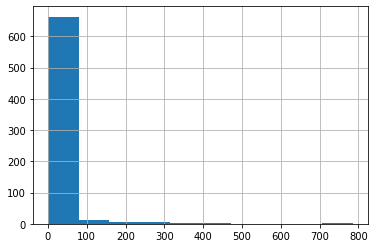

In [34]:
# train valid source length distribute
pd.Series(slb_train_src_len).value_counts().hist()
plt.show()

In [35]:
slb_train_tgt_len = slb_train_df["target"].str.len().tolist()
slb_valid_tgt_len = slb_valid_df["target"].str.len().tolist()
slb_train_tgt_len = slb_train_tgt_len + slb_valid_tgt_len
print(len(slb_train_tgt_len))
slb_train_tgt_len[:5]

11593


[214, 310, 227, 580, 9045]

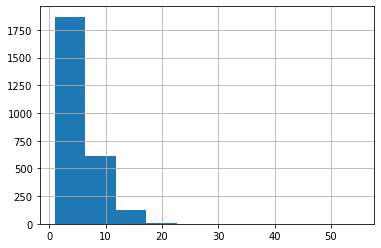

In [36]:
# train valid target length distribute
pd.Series(slb_train_tgt_len).value_counts().hist()
plt.show()

## long vs long

### A match

In [37]:
# lla train
lla_train = read_file("../data/raw/lla/train.txt", "train", "A")
lla_valid = read_file("../data/raw/lla/valid.txt", "train", "A")
lla_test = read_file("../data/raw/lla/test_with_id.txt", "test", "A")

lla_train_df = pd.DataFrame(lla_train, columns=train_columns)
lla_valid_df = pd.DataFrame(lla_valid, columns=train_columns)
lla_test_df = pd.DataFrame(lla_test, columns=test_columns)

print(f"sla train: {lla_train_df.shape}, sla valid: {lla_valid_df.shape}, sla test: {lla_test_df.shape}")

sla train: (10020, 3), sla valid: (1670, 3), sla test: (5010, 3)


In [38]:
print(lla_train_df.shape)
# lla train label distrubute
lla_train_dist = lla_train_df["label"].value_counts()
print("label distribute\n", lla_train_dist)
print(f"lla train label 0/1 distribute: {lla_train_dist[0] / lla_train_dist[1]:.4f}")
lla_train_df.head()

(10020, 3)
label distribute
 0    5538
1    4482
Name: label, dtype: int64
lla train label 0/1 distribute: 1.2356


,source,target,label
0,最近 你有没有约上好友一起去看电影？ 观影的感觉是不是很爽…… 不过 消防蜀黍在这里还得啰嗦...,最近 你有没有约上好友一起去看电影？ 观影的感觉是不是很爽…… 不过 消防蜀黍在这里还得啰嗦...,1
1,"就算韩国娱乐圈中新来的艺人是一个接着一个，""首席御姐""的座位也没有任何人去争抢。 这个位置能...","作为""霸道总裁""的王耀庆，即使不想成为一个演员。 却也因为自己的""手滑""填错了志愿，从此踏上...",0
2,1月13日， 在地铁3号线清江路站早高峰期间， 发生了这样惊险的一幕 事件回顾 7:40分...,千盼万盼 洛阳人离地铁越来越近 实拍！洛阳地铁1号线试运行...... （点击文字链接查看详...,1
3,新华社联合国1月7日电中国常驻联合国代表团发言人7日说，据媒体报道，美国国务卿蓬佩奥称美国常...,【美国常驻联合国代表克拉夫特访台计划取消，外交部回应】据路透社消息，美国国务院发言人12日宣...,1
4,自贡市管治结合，狠抓春季森林防火。 一是严格火源管控。全面实行护林护草人员在线巡护，在国有林...,“世界之大，无奇不有”在我们生活的这个世界上，生活着许许多多可爱又聪明的小动物！它们以一种憨...,0


In [39]:
print(lla_valid_df.shape)
# lla valid label distrubute
print("label distribute\n", lla_valid_df["label"].value_counts())
lla_valid_df.head()

(1670, 3)
label distribute
 0    904
1    766
Name: label, dtype: int64


,source,target,label
0,48岁吴绮莉现身避谈小龙女，主动提生父，对方墓地买好不愿回港 48岁吴绮莉现身避谈小龙女，主...,霍震霆与朱玲玲离婚后多年未娶妻，也没传绯闻，曝出实情令人遗憾。霍震霆子承父业，在香港也是非常...,0
1,网易娱乐1月24日报道1月24日，在昨晚播出的《怦然再心动》中王琳的儿子出镜，被网友称撞脸王...,年龄大了还会有爱情吗？有随便找人凑活的，也有一个人孤独终老的，在此，让我们看看“雪姨”王琳的...,1
2,《王牌对王牌》第六季正在播出。本赛季王牌家族队依旧是沈腾、贾玲、华晨宇、关晓彤4人。沈涛周围...,你为家人全力以赴 我们为你保持温度 焱魔方为你带来了 你不知道的那些故事 前不久在某档综艺节...,0
3,海外网1月12日电，当地时间1月9日，30岁的中国留美博士范轶然（音译）遭遇枪击，不幸身亡。...,当地时间1月14日，芝加哥大学为日前不幸遭遇枪杀的中国留学生范轶然举办追悼活动。芝加哥大学校...,1
4,南都此前关注报道的“美妆博主举报初中班主任曾性骚扰”一事迎来一审判决。1月13日，南都记者从...,近年来，健康保险业务发展快速，年均增速超过30%，受到社会各界广泛关注。短期健康险在快速发...,0


In [40]:
lla_train_src_len = lla_train_df["source"].str.len().tolist()
lla_valid_src_len = lla_valid_df["source"].str.len().tolist()
lla_train_src_len = lla_train_src_len + lla_valid_src_len
print(len(lla_train_src_len))
lla_train_src_len[:5]

11690


[818, 1505, 589, 377, 377]

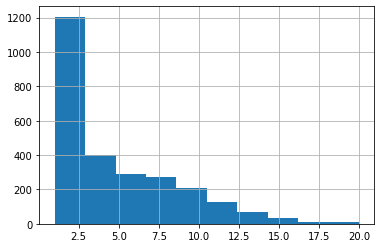

In [41]:
# train valid source length distribute
pd.Series(lla_train_src_len).value_counts().hist()
plt.show()

In [42]:
lla_train_tgt_len = lla_train_df["target"].str.len().tolist()
lla_valid_tgt_len = lla_valid_df["target"].str.len().tolist()
lla_train_tgt_len = lla_train_tgt_len + lla_valid_tgt_len
print(len(lla_train_tgt_len))
lla_train_tgt_len[:5]

11690


[835, 1455, 7703, 279, 582]

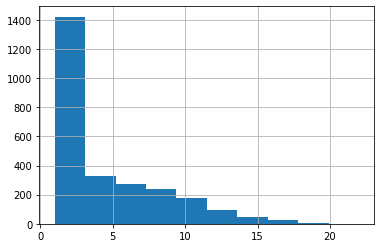

In [43]:
# train valid target length distribute
pd.Series(lla_train_tgt_len).value_counts().hist()
plt.show()

### B strict match

In [44]:
# llb train
llb_train = read_file("../data/raw/llb/train.txt", "train", "B")
llb_valid = read_file("../data/raw/llb/valid.txt", "train", "B")
llb_test = read_file("../data/raw/llb/test_with_id.txt", "test", "B")

llb_train_df = pd.DataFrame(llb_train, columns=train_columns)
llb_valid_df = pd.DataFrame(llb_valid, columns=train_columns)
llb_test_df = pd.DataFrame(llb_test, columns=test_columns)

print(f"llb train: {llb_train_df.shape}, llb valid: {llb_valid_df.shape}, llb test: {llb_test_df.shape}")

llb train: (10020, 3), llb valid: (1670, 3), llb test: (5010, 3)


In [45]:
print(llb_train_df.shape)
# llb train label distrubute
llb_train_dist = llb_train_df["label"].value_counts()
print("label distribute\n", llb_train_dist)
print(f"lla train label 0/1 distribute: {llb_train_dist[0] / llb_train_dist[1]:.4f}")
llb_train_df.head()

(10020, 3)
label distribute
 0    7757
1    2263
Name: label, dtype: int64
lla train label 0/1 distribute: 3.4278


,source,target,label
0,1月26日消息，今天NBA常规赛中，篮网主场以98-85战胜热火，双杀对手。本场比赛，篮网三...,今天NBA常规赛篮网和骑士的比赛堪称是万众瞩目，因为欧文在缺阵7场比赛之后终于归来，他和哈登...,0
1,北京时间1月21日，2020-21赛季NBA常规赛继续进行，金州勇士队在主场迎战圣安东尼奥马...,2020三水伟业达杯：改装踏板新人组总季军张铭洋 2020年三水森林赛车会摩托车大赛伟业达杯...,0
2,春暖开花季节就快要到了， 打起精神来， 有一大波好消息要告诉你！ 事关交通、教育、民生、补贴...,机器轰鸣声持续响起 冲破了海风的呼啸 吹响了起步冲锋的号角 3月2日，翔安区一季度12个项目...,0
3,曼联刚签下来自意甲亚特兰大球队前锋迪亚洛。对于这位球员，曼联名宿费迪南德也认为他能达到C罗的...,北京时间1月26日，国乒方面迎来好消息。最近，在全国青年锦标赛中取得好成绩的小将韩菲儿已经成...,0
4,近年来，为深入推进“人才强县”战略，黎平县在引、育、用上下功夫，通过政策扶持“引才”、示范引...,一是贫困地区缺少高端人才的用武之地。就像许多大学毕业生在北上广等一线城市才能找到合适的工作，...,0


In [46]:
print(llb_valid_df.shape)
# ssb valid label distrubute
print("label distribute\n", llb_valid_df["label"].value_counts())
llb_valid_df.head()

(1670, 3)
label distribute
 0    1265
1     405
Name: label, dtype: int64


,source,target,label
0,来源：综合自中国青年报、人民网、河南省教育厅、学校共青团、各高校网站等 近日，教育部印发提醒...,中国青年网北京2月14日电（记者陈子君）2021年2月11日，是中国传统农历中的大年三十，也...,0
1,罗志祥，娱乐圈内颇为知名的一位艺人了，不管是在出事前还是出事后，他都是如此的有流量。可以说罗...,罗志祥自从与周扬青分手之后就淡出了娱乐圈，由于分手时周扬青发出的长文爆料，也是让罗志祥身上多...,1
2,中国经济网北京2月2日讯（记者马先震孙辰炜）日前，国家市场监督管理总局网站公布了广州小鹏汽车...,新华社发表文章《瞭望|特斯拉恶意甩锅是对中国消费者的无理傲慢》。称特斯拉召回车辆却在海外不认...,0
3,👆点击进入珠海通小程序，免费发布便民信息 《巴啦啦小魔仙》相信很多人都看过， 但今天下午传来...,近日，有网友晒出了陈翔回到四川文化艺术学院，与母校签约的画面，他将正式入职当老师，在合约期内...,0
4,提起香港乐坛，人们首先就会想到四大天王，大家会想到郭富城，黎明，张学友，刘德华，他们每一个都...,昨晚，''2021年春节联欢晚会''如愿以偿，牛年春晚，哪里是最大的亮点？网友的回答令人惊讶...,0


In [47]:
llb_train_src_len = llb_train_df["source"].str.len().tolist()
llb_valid_src_len = llb_valid_df["source"].str.len().tolist()
llb_train_src_len = llb_train_src_len + llb_valid_src_len
print(len(llb_train_src_len))
llb_train_src_len[:5]

11690


[968, 1214, 5156, 617, 773]

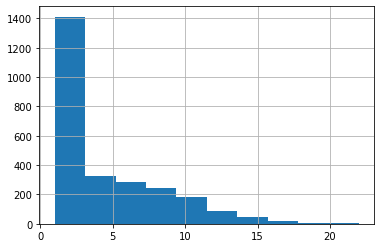

In [48]:
# train valid source length distribute
pd.Series(llb_train_src_len).value_counts().hist()
plt.show()

In [49]:
llb_train_tgt_len = llb_train_df["target"].str.len().tolist()
llb_valid_tgt_len = llb_valid_df["target"].str.len().tolist()
llb_train_tgt_len = llb_train_tgt_len + llb_valid_tgt_len
print(len(llb_train_tgt_len))
llb_train_tgt_len[:5]

11690


[543, 478, 1466, 796, 426]

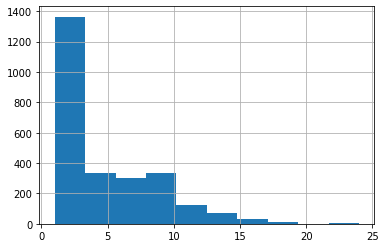

In [50]:
# train valid target length distribute
pd.Series(llb_train_tgt_len).value_counts().hist()
plt.show()

## merge data

In [51]:
train_data = pd.concat([ssa_train_df, ssb_train_df, sla_train_df, slb_train_df, lla_train_df, llb_train_df])
valid_data = pd.concat([ssa_valid_df, ssb_valid_df, sla_valid_df, slb_valid_df, lla_valid_df, llb_valid_df])
test_data  = pd.concat([ssa_test_df,  ssb_test_df,  sla_test_df,  slb_test_df,  lla_test_df,  llb_test_df])

In [52]:
print(train_data.shape)
train_data.head()

(59638, 3)


,source,target,label
0,谁能打破科比81分纪录？奥尼尔给出5个候选人，补充利拉德比尔！,NBA现役能入名人堂的球星很多，但是能被立铜像只有2人,0
1,请扩散！明天，黄金埠这些地方会停电！,生活｜这几个地方注意啦！1月12日有部分线路停电检修,0
2,居家健身增强免疫！（三）,原来是背影杀手#你愿意和我做朋友吗#户外健身,0
3,太极拳罗师傅被洋人打伤，叶问霸气复仇？,非常完美：感动！女嘉宾告白赵杰被拒绝，尹康霸气上台挽留！,0
4,恭喜哈登！篮网因祸得福，29+7超巨大概率复出，3换4交易方案出炉,三英缺席杜兰特，篮网迎战湖人NBA重头大戏！,1


In [53]:
print(valid_data.shape)
valid_data.head()

(9940, 3)


,source,target,label
0,【春节档】据说《刺杀小说家》是全宇宙最好的剧组,《刺杀小说家》两个世界，一场奇幻冒险！,1
1,央广网北京2月25日消息（记者韩靖陈锐海）2021年2月25日16时，北京市朝阳区太阳宫北街...,据@新华视点消息，2021年2月25日16时，北京市朝阳区太阳宫北街1号，国家乡村振兴局牌子...,1
2,晒晒主持人程雷的豪宅，小区看起来有些年头，生活过得普通又节俭,带你参观张铎的豪宅，跟老婆生活很恩爱，在家餐厅布置非常浪漫,0
3,当时，勇士成功进行了24秒的防守，导致马刺未能将球打进。在格林准备发球的时候，德罗赞走向库里...,这场比赛，勇士队状态非常好，库里与乌布雷首节联手轰下25分，帮助勇士队取得领先。这场比赛，格...,1
4,凡是不愿说破的，也最怕别人点透,“小阎罗”茸主第二局TKO‘牧马人“毕德力雅，成功卫冕金腰带,0


In [54]:
print(test_data.shape)
test_data.head()

(29822, 3)


,source,target,id
0,北京顺义2个地区调整为低风险地区,黑龙江省大庆市中风险地区清零全域调为低风险,ss0_a
1,库里夺冠希望渺茫！荣誉或就此而止，退役后进不了历史前十,维金斯：勇士文化是不同的这可能是我生涯最开心的阶段,ss1_a
2,过年了，过年了！,就地过年的你，许愿吗？,ss2_a
3,你见过被噎死的蛇吗？这条蛇自作自受吞下庞然大物把自己给撑死了！,这种瓜有人从来没见过，这里却做全瓜宴,ss3_a
4,如果你喜欢关注足球赛事、喜欢讨论赛事战术打法、了解豪门球队背后的历史渊源、喜爱投资足彩竞彩…...,大家好，我是小狼！前天利物浦客场3:1击败铁锤帮西汉姆联，红军打进的第二个进球太漂亮了，就像...,ss4_a


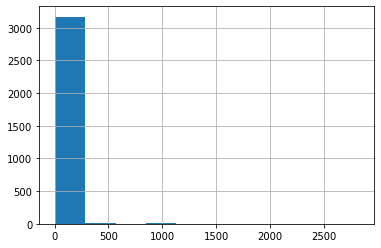

In [55]:
train_data["source"].str.len().value_counts().hist()

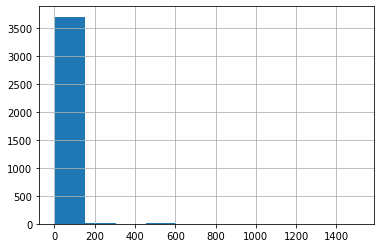

In [56]:
train_data["target"].str.len().value_counts().hist()

In [57]:
train_data["source"].str.len().describe()

count    59638.000000
mean       414.683759
std        842.287759
min          3.000000
25%         28.000000
50%        121.000000
75%        598.000000
max      77827.000000
Name: source, dtype: float64

In [58]:
train_data["target"].str.len().describe()

count    59638.000000
mean       690.851974
std        936.114293
min          3.000000
25%         92.000000
50%        509.000000
75%        974.000000
max      45327.000000
Name: target, dtype: float64

## write to file

In [17]:
def write2file(df: pd.DataFrame, path: str = None):
    df.to_csv(path, index=False, sep="\t")
    print(f"write to {path} success.")

In [19]:
write2file(ssa_train_df, "../data/clean/train.csv")
write2file(ssa_valid_df, "../data/clean/valid.csv")
write2file(ssa_test_df, "../data/clean/test.csv")

write to ../data/clean/train.csv success.
write to ../data/clean/valid.csv success.
write to ../data/clean/test.csv success.


In [18]:
write2file(train_data, "../data/clean/train.csv")
write2file(valid_data, "../data/clean/valid.csv")
write2file(test_data, "../data/clean/test.csv")

NameError: name 'train_data' is not defined

In [62]:
test_data.tail(100)

,source,target,id
4910,2月27日下午17时，香港电影金牌绿叶、演员吴孟达因肝癌在香港离世，享年68岁。详情>> 周...,2021年2月27日，香港著名喜剧演员吴孟达去世，享年70岁。吴孟达好友田启文曾透露，吴孟...,ll4910_b
4911,最喜欢出访的美国国务卿蓬佩奥日前突然取消了可能是他任内的最后一次出访计划，让外界着实吃了一惊...,中新社北京1月14日电题：美式“双标”反恐贻害无穷 中新社记者马佳佳 近日，美国国务院重新将...,ll4911_b
4912,【来自国新办新闻发布会的报道】 2020年是防范化解金融风险攻坚战的收官之年。银行保险业在金...,3月2日，国新办举行推动银行业保险业高质量发展新闻发布会，银保监会主席郭树清和有关银行保险机...,ll4912_b
4913,为配合各地政府落实疫情防控常态化措施，避免重复购票退票给旅客带来不便，自发售2021年2月1...,为加强疫情防控工作，严防疫情反弹，近日，我镇加强“三人小组”开展常态化疫情防控工作，对各村（...,ll4913_b
4914,皇家马德里在2014年开启了5年4次获得欧冠冠军的白色王朝，瓦拉内和拉莫斯从7年前成为皇马...,本赛季的皇马已经出现了一系列的问题，虽然现在的球队依然拥有联赛排名第二的位置，但是夺冠优势并...,ll4914_b
4915,来源：央视新闻客户端 2021-02-2415:42 2月24日，陕西渭南澄城出现持续性大范...,邯郸市气象台于24日晚上的22时36分发布了暴雪蓝色预警信号：预计24小时内邯郸市区降雪总量...,ll4915_b
4916,每经编辑：杜宇 据“山东教育发布”微信公号2月18日消息，为贯彻落实党中央、国务院《深化新时...,中新网2月18日电据山东省教育厅微信公众号消息，根据教育部等九部门《关于印发中小学生减负措施...,ll4916_b
4917,排球女神进日本发展，清纯不再变妖艳网红脸，现今男友是摄影师 众所周知，排球运动中的运动员因为...,高亭宇，1997年12月15日出生于黑龙江省伊春市。 2005年，高亭宇开始接触滑冰。20...,ll4917_b
4918,“呦！老张，今儿这么帅，去哪儿啊？” “啊？坏？老李，说啥呢？我哪儿坏了？” “不是啊！是帅...,你的假期余额已严重不足，明天，就要上班了！ 这个春节，你是怎么过的？ 是和亲朋好友一起逛吃...,ll4918_b
4919,“男人不讨厌她，女人不嫉妒她”，这是沈腾对贾玲的一句非常中肯的评价。 不仅仅是在娱乐圈人缘...,2月24日，34岁的沛县十八线功夫演员“现代李小龙”飞龙就近期大红大紫的女导演贾玲公开抨击，...,ll4919_b


## k-fold

In [60]:
train_valid = pd.concat([train_data, valid_data])
train_valid = train_valid.sample(frac=1)
print(train_valid.shape)
train_valid.head()

(69578, 3)


,source,target,label
3962,肖战欠鹅厂一部戏？糊咖时期的资源置换被曝，3月进组板上钉钉,当下各种电视剧作品，都已经是官宣杀青了，有的都开始定档播出，像是《上阳赋》、《山海情》、《江...,0
3019,古力娜扎陈晓拍新剧同框俊男美女十分养眼,美女不相信王宝强有车，王宝强在车库把车变出来，吓美女一跳！,0
1093,今年，贵阳市凤冈商会准备这样干 2021年3月3日，贵阳市凤冈商会第一届第一次理事会议暨共谋...,为进一步提升郯城县消防救援队伍正规化、专业化、职业化建设水平，持续壮大郯城县政府专职消防员队...,0
2988,新赛季的中超联赛已经进入到冬训期，而在近期各支球队的引援工作已经展开，而在近日沪媒《东方体育...,北京时间1月15号，媒体上更新了中超新科冠军江苏苏宁的消息，据《东方体育日报》爆料，目前江苏...,0
7218,《大红包》提档1月22日，特笑天团、提钱贺岁！,本次包贝尔、张一鸣、贾冰、许君聪、王小利组成“包笑男孩儿”男团，加上性感女神克拉拉的喜感王炸...,1


In [61]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
k = 0
for i, (train_idx, valid_idx) in enumerate(kf.split(train_valid)):
    print(i+1)
    train = train_valid.iloc[train_idx]
    valid = train_valid.iloc[valid_idx]
    write2file(train, f"../data/clean/k_fold/k_fold{i+1}/train.csv")
    write2file(valid, f"../data/clean/k_fold/k_fold{i+1}/valid.csv")

1
write to ../data/clean/k_fold/k_fold1/train.csv success.
write to ../data/clean/k_fold/k_fold1/valid.csv success.
2
write to ../data/clean/k_fold/k_fold2/train.csv success.
write to ../data/clean/k_fold/k_fold2/valid.csv success.
3
write to ../data/clean/k_fold/k_fold3/train.csv success.
write to ../data/clean/k_fold/k_fold3/valid.csv success.
4
write to ../data/clean/k_fold/k_fold4/train.csv success.
write to ../data/clean/k_fold/k_fold4/valid.csv success.
5
write to ../data/clean/k_fold/k_fold5/train.csv success.
write to ../data/clean/k_fold/k_fold5/valid.csv success.


## A, B split

In [ ]:
train_a = pd.concat([ssa_train])